In [208]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression



In [209]:
df = pd.read_csv('../resources/openstack/log-structured/OpenStack.log_sequences.csv')

In [210]:
X = df.iloc[:, 1:-1].values
y = df["Severity"].values
print(X.shape, y.shape)

(939, 62) (939,)


In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [212]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [213]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()


In [214]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)


In [215]:
# criterion = nn.BCELoss()  # binary cross-entropy
# optimizer = optim.SGD(model.parameters(), lr=0.1)

In [216]:
model.fit(X_train, y_train_flat)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [217]:
y_pred = model.predict(X_test)


In [218]:
y_pred_np = y_pred  # flatten to 1D
y_test_np = y_test.numpy().flatten()

print("Predicted labels:", y_pred_np)

accuracy = accuracy_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1:.2f}")


Predicted labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy: 95.74%
Recall: 100.00%
F1 Score: 0.56


In [219]:
coefficients = model.coef_.flatten()  # shape (n_features,)
event_names = list(df.columns)[1:-1] # if hasattr(X_train, 'columns') else [f"E{i+1}" for i in range(len(coefficients))]

feature_importance = pd.DataFrame({
    "EventId": event_names,
    "Coefficient": coefficients
})

# Sort by absolute value
feature_importance["Importance"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance.head(10))

             EventId  Coefficient  Importance
43  request-416be887    -3.817742    3.817742
42  request-3bc56d04    -2.725254    2.725254
36  request-2290cbde    -2.657718    2.657718
41  request-34587f11    -1.865171    1.865171
55  request-a17e98d9    -1.211599    1.211599
46  request-5b709354    -1.166377    1.166377
31  request-002b412c     1.090946    1.090946
39  request-31318a67     1.090946    1.090946
1     other-046cebb5     1.090946    1.090946
21    other-a44f2c0c     1.090946    1.090946


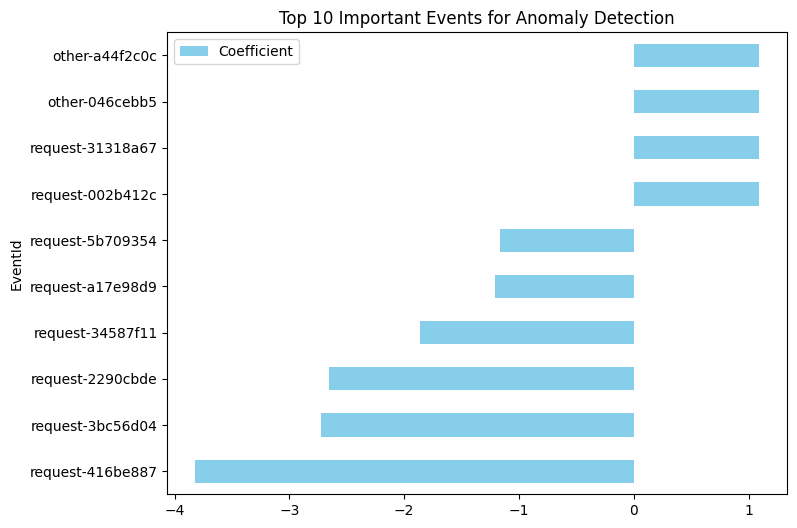

In [220]:
import matplotlib.pyplot as plt

feature_importance.head(10).plot(
    x="EventId", y="Coefficient", kind="barh", figsize=(8,6), color="skyblue"
)
plt.title("Top 10 Important Events for Anomaly Detection")
plt.show()
